# Cliff Walking: Q Learning vs Sarsa vs Expected Sarsa

I recreated the experiment originally done in "A Theoretical and Empirical Analysis of Expected Sarsa" van Seijen et al. 2009, which was then highlighted in the RL book (Sutton. The essence of the problem is as follows: the agent starts at the left bottom most side of a grid and must reach the right bottom most side to end the task, it recieves a reward of -1 at each time step, and a -100 reward if it steps into the cliff located all along the bottom row of the grid (except for the start and goal states). Q learning essentially evaluates the greedy policy and thus learns to take the riskiest path across the board. On the other hand sarsa being on-policy should be able to learn to take a safer route, however, i considered the case where the learning rate $\alpha$ was set to 1 and thus sarsa is unstable due to the stochasticity in the policy. Finally expected sarsa succeeds in finding the safe path since it effectively evaluates the expected policy. 

In [1]:
import numpy as np
from copy import deepcopy

class Cliff(object):
    def __init__(self, grid_x=4, grid_y=12, max_steps=1000):
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.num_states = grid_x * grid_y
        self.state_shape = [self.num_states]
        self.nb_actions = 4
        self.state = np.zeros((self.num_states), dtype='float32')
        self.max_steps = max_steps
        self.start_pos = [0, 0]
        self.pos = np.array(self.start_pos, dtype='int32')
        self.goal_state = np.array([self.grid_x - 1, 0], dtype='int32')
        self.counter = 0
        
    def observe(self):
        return np.copy(self.state) 

    def _is_over(self):
        # exit or max number of steps
        return np.all(self.pos == self.goal_state) or (0 < self.pos[0] < self.grid_x - 1 and self.pos[1] == 0) or \
               self.counter >= self.max_steps 

    def _update_state(self, action):
        # no-op
        if (action == 0 and self.pos[0] == 0) or (action == 1 and self.pos[0] == self.grid_x - 1) or \
           (action == 2 and self.pos[1] == 0) or (action == 3 and self.pos[1] == self.grid_y - 1):  
            pass
        elif action == 0:  # move left
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[(self.pos[0] - 1) * self.grid_x + self.pos[1]] = 1
            self.pos[0] -= 1
        elif action == 1:  # move right
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[(self.pos[0] + 1) * self.grid_x + self.pos[1]] = 1
            self.pos[0] += 1
        elif action == 2:  # move down
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[self.pos[0] * self.grid_x + self.pos[1] - 1] = 1
            self.pos[1] -= 1
        elif action == 3:  # move up
            self.state = np.zeros((self.num_states), dtype='float32')
            self.state[self.pos[0] * self.grid_x + self.pos[1] + 1] = 1
            self.pos[1] += 1
    
    def _get_reward(self):
        if np.all(self.pos == self.goal_state):
            return 0
        elif  0 < self.pos[0] < self.grid_x - 1 and self.pos[1] == 0:
            return -100
        else:
            return -1
    
    def act(self, action):
        assert action == 0 or action == 1 or action == 2 or action == 3
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        self.counter += 1
        return np.copy(self.state), reward, game_over
        
    def reset(self):
        self.state = np.zeros((self.num_states), dtype='float32')
        self.state[self.start_pos] = 1
        self.pos = np.array(self.start_pos, dtype='int32')
        self.counter = 0

In [2]:
class Agent(object):
    def __init__(self, state_shape, nb_actions, gamma=0.99, lr=1.0, algo='q', epsilon=0.1):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.gamma = gamma
        self.lr = lr
        self.algo = algo
        self.epsilon = epsilon
        self.table = np.zeros((state_shape[0], nb_actions))
    
    def _predict(self, state):
        return self.table[np.argmax(state[0])]
    
    def _train(self, sarst, a2=None):
        s, a, r, s2, t = sarst
        q = self.table[np.argmax(s)][a]
        if self.algo == 'q':
            target = r + (1 - t) * self.gamma * np.max(self.table[np.argmax(s2)])
        elif self.algo == 'sarsa':
            target = r + (1 - t) * self.gamma * self.table[np.argmax(s2)][a2]
        elif self.algo == 'expected_sarsa':
            probs = np.ones(self.nb_actions)
            probs *= self.epsilon / self.nb_actions
            probs[np.argmax(self.table[np.argmax(s2)])] = 1 - self.epsilon
            target = r + (1 - t) * self.gamma * np.sum(probs * self.table[np.argmax(s2)])
        self.table[np.argmax(s)][a] += self.lr * (target - q)

    def get_action(self, state, epsilon):
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            q = self._predict([state])
            return np.argmax(q)

    def learn(self, s, a, r, s2, t, a2=None):
        return self._train([s, a, r, s2, t], a2=a2)
    
    def reset(self):
        self.table = np.zeros((self.state_shape[0], self.nb_actions))

In [3]:
import numpy as np
import pickle

nb_runs_each = 10
nb_episodes = 1000
epsilon = 0.1
algos = ['q', 'sarsa', 'expected_sarsa']

env = Cliff()
agents = [Agent(env.state_shape, env.nb_actions, algo=algo, epsilon=epsilon) for algo in algos]
all_agent_cumul_rewards = np.empty((nb_runs_each, nb_episodes, len(agents)))
all_agent_ep_rewards = np.empty((nb_runs_each, nb_episodes, len(agents)))

def do_episode(env, agent, epsilon=1.0):
    env.reset()
    terminal = False
    reward = 0
    actions = []
    s = env.observe()
    a = agent.get_action(s, epsilon=epsilon)
    while not terminal:
        s2, r, terminal = env.act(a)
        a2 = agent.get_action(s2, epsilon=epsilon)
        agent.learn(s, a, r, s2, terminal, a2=a2)
        reward += r 
        actions.append(a)
        s = s2
        a = a2
    return reward, actions
    
for agent_index, agent in enumerate(agents):
    for run in range(nb_runs_each):
        agent.reset()
        cumul_rewards = 0
        for ep in range(nb_episodes):
            ep_reward, _ = do_episode(env, agent, epsilon)
            cumul_rewards += ep_reward
            all_agent_cumul_rewards[run, ep, agent_index] = cumul_rewards
            all_agent_ep_rewards[run, ep, agent_index] = ep_reward
            
with open('cumul_rewards', 'wb') as f:
    pickle.dump(all_agent_cumul_rewards, f)
with open('ep_rewards', 'wb') as f:
    pickle.dump(all_agent_ep_rewards, f)

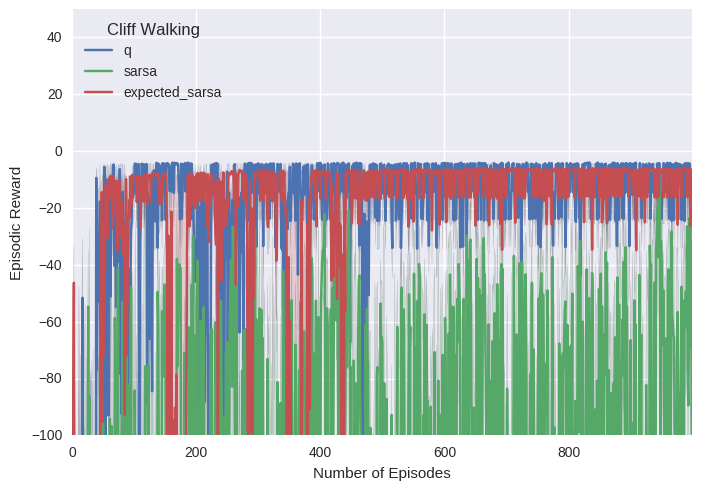

In [4]:
%matplotlib inline
import pickle
import seaborn
import matplotlib.pyplot as plt
with open('ep_rewards', 'rb') as f:
     all_agent_ep_rewards = pickle.load(f)

plot = seaborn.tsplot(data=all_agent_ep_rewards, legend=True, condition=algos)
plot.legend(loc='upper left', title='Cliff Walking')
plt.ylim(-100, 50)
plot.set_ylabel("Episodic Reward")
plot.set_xlabel("Number of Episodes")

In [5]:
# view learned polices
int_to_action = ['Left', 'Right', 'Down', 'Up']
for agent_index, agent in enumerate(agents):
    reward, actions = do_episode(env, agent, epsilon=0.0)
    action_words = [int_to_action[a] for a in actions]
    print('Agent: ' + str(agent.algo), "| Actions : ", action_words, "| Reward ", reward)

Agent: q | Actions :  ['Up', 'Right', 'Right', 'Right', 'Down'] | Reward  -4
Agent: sarsa | Actions :  ['Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 